In [448]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [449]:
pip install --index-url=https://pypi.org/simple/ pycaret

Looking in indexes: https://pypi.org/simple/


In [490]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from pycaret.regression import *

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [451]:
def Preprocess_Pipeline(df):

    df = df.drop(["Name", "Ticket", "Cabin"], axis=1)
    Sex_OneHotEncoded = pd.get_dummies(df["Sex"], drop_first=True)
    df = df.drop("Sex", axis=1)
    df["Sex"] = Sex_OneHotEncoded


    Embarked_OneHotEncoded = pd.get_dummies(df["Embarked"], drop_first = True)
    df = df.drop("Embarked", axis=1)
    df = pd.concat([df, Embarked_OneHotEncoded], axis = 1)


    # Calculate the correlation matrix
    correlation_matrix = df.corr()
    # Set the threshold for correlation
    threshold = 0.9
    # Find highly correlated columns
    highly_correlated_cols = set()
    cols = correlation_matrix.columns
    for i in range(len(cols)):
        for j in range(i):
            if correlation_matrix.iloc[i, j] >= threshold:
                colname = correlation_matrix.columns[i]
                highly_correlated_cols.add(colname)
    # Drop highly correlated columns
    df = df.drop(columns=highly_correlated_cols)


    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    # Columns to impute
    columns_to_impute = ['Age', 'Fare']
    # Fitting the imputer on the data and transforming it
    transformed = imputer.fit_transform(df[columns_to_impute])
    df = df.drop(["Age", "Fare"], axis = 1)
    df = pd.concat([df, pd.DataFrame(transformed, columns = columns_to_impute)], axis = 1)


    return df

In [452]:
dataset = pd.read_csv("/content/train.csv")
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [453]:
dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [454]:
dataset.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [455]:
print(dataset.shape)
print(dataset.isnull().sum())

(891, 12)
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [456]:
dataset = dataset.drop(["Name", "Ticket", "Cabin"], axis=1)

In [457]:
Sex_OneHotEncoded = pd.get_dummies(dataset["Sex"], drop_first=True)
dataset.drop("Sex", axis=1)
dataset["Sex"] = Sex_OneHotEncoded

In [458]:
Embarked_OneHotEncoded = pd.get_dummies(dataset["Embarked"], drop_first = True)
dataset = dataset.drop("Embarked", axis=1)
dataset = pd.concat([dataset, Embarked_OneHotEncoded], axis = 1)

In [459]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Q,S
0,1,0,3,1,22.0,1,0,7.2500,0,1
1,2,1,1,0,38.0,1,0,71.2833,0,0
2,3,1,3,0,26.0,0,0,7.9250,0,1
3,4,1,1,0,35.0,1,0,53.1000,0,1
4,5,0,3,1,35.0,0,0,8.0500,0,1


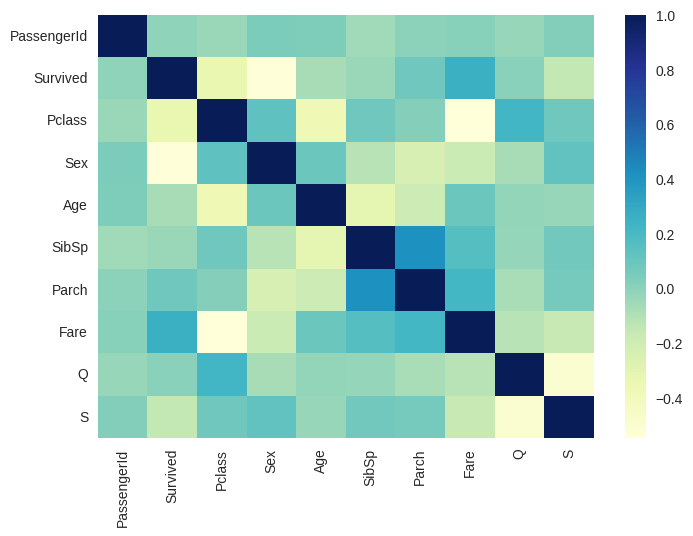

In [460]:
sns.heatmap(dataset.corr(), cmap="YlGnBu")
plt.show()

In [461]:
dataset.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Q                0
S                0
dtype: int64

In [462]:
dataset.shape

(891, 10)

In [463]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(dataset[['Age']])
SimpleImputer()
transformed_age = imp_mean.transform(dataset[['Age']])

dataset = dataset.drop("Age", axis = 1)
dataset = pd.concat([dataset, pd.DataFrame(transformed_age, columns = ["Age"])], axis = 1)

dataset.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Q,S,Age
0,1,0,3,1,1,0,7.2500,0,1,22.0
1,2,1,1,0,1,0,71.2833,0,0,38.0
2,3,1,3,0,0,0,7.9250,0,1,26.0
3,4,1,1,0,1,0,53.1000,0,1,35.0
4,5,0,3,1,0,0,8.0500,0,1,35.0


In [464]:
dataset.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
SibSp          0
Parch          0
Fare           0
Q              0
S              0
Age            0
dtype: int64

In [465]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_indices, test_indices in split.split(dataset, dataset[["Survived", "Pclass", "Sex"]]):
    Train_data = dataset.loc[train_indices]
    Test_data = dataset.loc[test_indices]

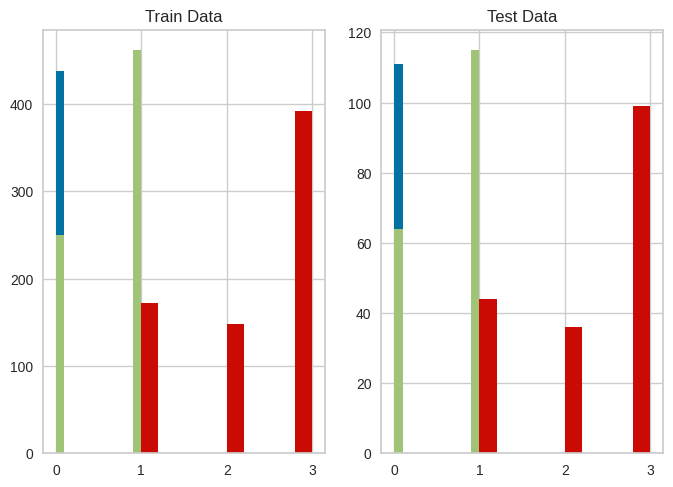

In [466]:
plt.subplot(1, 2, 1)
Train_data['Survived'].hist()
Train_data['Sex'].hist()
Train_data['Pclass'].hist()
plt.title("Train Data")

plt.subplot(1, 2, 2)
Test_data['Survived'].hist()
Test_data['Sex'].hist()
Test_data['Pclass'].hist()
plt.title("Test Data")

plt.show()

In [467]:
Train_data.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Q,S,Age
867,868,0,1,1,0,0,50.4958,0,1,31.0
619,620,0,2,1,0,0,10.5000,0,1,26.0
50,51,0,3,1,4,1,39.6875,0,1,7.0
286,287,1,3,1,0,0,9.5000,0,1,30.0
834,835,0,3,1,0,0,8.3000,0,1,18.0


In [468]:
Train_data.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Q,S,Age
867,868,0,1,1,0,0,50.4958,0,1,31.0
619,620,0,2,1,0,0,10.5000,0,1,26.0
50,51,0,3,1,4,1,39.6875,0,1,7.0
286,287,1,3,1,0,0,9.5000,0,1,30.0
834,835,0,3,1,0,0,8.3000,0,1,18.0


In [469]:
Test_data.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Q,S,Age
659,660,0,1,1,0,2,113.2750,0,0,58.00
119,120,0,3,0,4,2,31.2750,0,1,2.00
875,876,1,3,0,0,0,7.2250,0,0,15.00
67,68,0,3,1,0,0,8.1583,0,1,19.00
644,645,1,3,0,2,1,19.2583,0,0,0.75


In [470]:
X_train = Train_data.drop(["Survived", "PassengerId"], axis = 1)
y_train = Train_data["Survived"]

X_test = Test_data.drop(["Survived", "PassengerId"], axis = 1)
y_test = Test_data["Survived"]

In [471]:
temp = X_train['Fare']
X_train = X_train.drop('Fare', axis = 1)
X_train = pd.concat([X_train, temp], axis = 1)

temp = X_test['Fare']
X_test = X_test.drop('Fare', axis = 1)
X_test = pd.concat([X_test, temp], axis = 1)

In [472]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(712, 8) (179, 8)
(712,) (179,)


In [473]:
# Creating and training the linear regression model
LRmodel = LinearSVC()
LRmodel.fit(X_train, y_train)

# Making predictions on the test set
y_pred = np.round(LRmodel.predict(X_test)).astype(int)

# Calculating the Accuracy
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc}")

Accuracy: 0.6815642458100558


In [502]:
# Creating and training the XGBoost regression model
XGBmodel = XGBClassifier(n_estimators=100, max_depth=3, gamma = 0.15)
XGBmodel.fit(X_train, y_train)

# Making predictions on the test set
y_pred = (XGBmodel.predict(X_test))

# Calculating the Accuracy
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc}")

Accuracy: 0.8044692737430168


In [501]:
# Creating and training the Decision Tree Regression model
DTRModel = DecisionTreeClassifier(criterion = 'entropy', max_depth=4)
DTRModel.fit(X_train, y_train)

# Making predictions on the test set
y_pred = (DTRModel.predict(X_test))

# Calculating the Accuracy
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc}")

Accuracy: 0.8268156424581006


In [497]:
# Creating and training the Random Forest Regression model
RFRmodel = RandomForestClassifier(n_estimators=300)
RFRmodel.fit(X_train, y_train)

# Making predictions on the test set
y_pred = (RFRmodel.predict(X_test))

# Calculating the Accuracy
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc}")

Accuracy: 0.770949720670391


In [493]:
# Creating and training the Extra Trees Regression model
ETRmodel = ExtraTreesClassifier(n_estimators=200)
ETRmodel.fit(X_train, y_train)

# Making predictions on the test set
y_pred = ETRmodel.predict(X_test)

# Calculating the Accuracy
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc}")

Accuracy: 0.7374301675977654


In [492]:
# Creating the K-Nearest Neighbors (KNN) classifier model
KNNmodel = KNeighborsClassifier(n_neighbors=5)  # Set the number of neighbors

# Training the model
KNNmodel.fit(X_train, y_train)

# Making predictions on the test set
y_pred = KNNmodel.predict(X_test)

# Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.7039106145251397


In [478]:
# Initialize the regression setup
regression_setup = setup(data=dataset, target='Survived', train_size=0.8)

# Compare different regression models
best_model = compare_models()

In [479]:
from sklearn.ensemble import GradientBoostingClassifier

# Creating and training the Gradient Boosting Regression model
GBRmodel = GradientBoostingClassifier(n_estimators=100, random_state=0)
GBRmodel.fit(X_train, y_train.ravel())  # ravel y_train to remove extra dimensions

# Making predictions on the test set
y_pred = GBRmodel.predict(X_test)

# Calculating the Accuracy
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc}")

Accuracy: 0.8044692737430168


In [480]:
# Creating the ANN model
ANNmodel = keras.Sequential([
    layers.Input(shape=X_train.shape[1]),  # Input layer with 10 features
    layers.Dense(100, activation='relu'),  # Hidden layer with 16 neurons and ReLU activation
    layers.Dense(10, activation='relu'),   # Hidden layer with 8 neurons and ReLU activation
    layers.Dense(1, activation = 'sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compiling the model
ANNmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
ANNmodel.fit(X_train, y_train, epochs=20, validation_data = (X_test, y_test))

# Evaluating the model on the test set
ANN_preds = ANNmodel.evaluate(X_test, y_test)

Epoch 1/20
23/23 [==============================] - 1s 11ms/step - loss: 0.7487 - accuracy: 0.5183 - val_loss: 0.6925 - val_accuracy: 0.6760
Epoch 2/20
23/23 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.6264 - val_loss: 0.6905 - val_accuracy: 0.6201
Epoch 3/20
23/23 [==============================] - 0s 9ms/step - loss: 0.6898 - accuracy: 0.6152 - val_loss: 0.6886 - val_accuracy: 0.6201
Epoch 4/20
23/23 [==============================] - 0s 7ms/step - loss: 0.6880 - accuracy: 0.6152 - val_loss: 0.6868 - val_accuracy: 0.6201
Epoch 5/20
23/23 [==============================] - 0s 8ms/step - loss: 0.6864 - accuracy: 0.6152 - val_loss: 0.6850 - val_accuracy: 0.6201
Epoch 6/20
23/23 [==============================] - 0s 9ms/step - loss: 0.6847 - accuracy: 0.6152 - val_loss: 0.6834 - val_accuracy: 0.6201
Epoch 7/20
23/23 [==============================] - 0s 7ms/step - loss: 0.6833 - accuracy: 0.6152 - val_loss: 0.6821 - val_accuracy: 0.6201
Epoch 8/20
23/23 [=

In [481]:
# # Create a regression model using the best-performing algorithm
# final_model = create_model(best_model)

# # Make predictions on the test set
# predictions = predict_model(final_model)
# predictions

In [482]:
test = pd.read_csv("/content/test.csv")
test = Preprocess_Pipeline(test)

In [483]:
test.head()

,PassengerId,Pclass,Sex,SibSp,Parch,Q,S,Age,Fare
0,892,3,1,0,0,1,0,34.5,7.8292
1,893,3,0,1,0,0,1,47.0,7.0000
2,894,2,1,0,0,1,0,62.0,9.6875
3,895,3,1,0,0,0,1,27.0,8.6625
4,896,3,0,1,1,0,1,22.0,12.2875


In [503]:
test_preds = DTRModel.predict(test.drop("PassengerId", axis = 1))
test_preds

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [504]:
sub = pd.read_csv('/content/gender_submission.csv')
sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [505]:
Submission = pd.concat([test["PassengerId"], pd.DataFrame(test_preds)], axis = 1)
Submission.columns = ["PassengerId", "Survived"]
Submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [506]:
# Specify the file path to delete
file_path = '/content/submissions.csv'  # Replace with the actual file path

# Check if the file exists before attempting to delete
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"File '{file_path}' deleted successfully.")
else:
    print(f"File '{file_path}' does not exist.")

File '/content/submissions.csv' deleted successfully.


In [507]:
# Save the DataFrame to a CSV file
csv_file_path = '/content/submissions.csv'
Submission.to_csv(csv_file_path, index=False)

In [508]:
pd.read_csv("/content/submissions.csv").head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
